In [2]:
import torch
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision.transforms import transforms
import torch.nn.functional as F

In [17]:
class Encoder(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(in_features=kwargs["input_shape"], out_features=128)
        self.encoder_output_layer = nn.Linear(in_features=128, out_features=16)
    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(activation)
        code = self.encoder_output_layer(activation)
        code = torch.relu(code)
        code = torch.nn.functional.normalize(code, p=2.0, dim=1) # Normalize the latent vector
        return code
    
class Decoder(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.decoder_hidden_layer = nn.Linear(in_features=16, out_features=128)
        self.decoder_output_layer = nn.Linear(in_features=128, out_features=kwargs["input_shape"])

    def forward(self, code):
        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.relu(activation)
        return reconstructed

class AE(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder = Encoder(input_shape=784)
        self.decoder = Decoder(input_shape=784)
    def forward(self, x):
        encoded = self.encoder(x)
        return self.decoder(encoded)
        
#         self.encoder_hidden_layer = nn.Linear(in_features=kwargs["input_shape"], out_features=128)
#         self.encoder_output_layer = nn.Linear(in_features=128, out_features=16)
#         self.decoder_hidden_layer = nn.Linear(in_features=16, out_features=128)
#         self.decoder_output_layer = nn.Linear(in_features=128, out_features=kwargs["input_shape"])

#     def forward(self, features):
#         activation = self.encoder_hidden_layer(features)
#         activation = torch.relu(activation)
#         code = self.encoder_output_layer(activation)
#         code = torch.relu(code)
#         code = torch.nn.functional.normalize(code, p=2.0, dim = 1) # Normalize the latent vector
#         activation = self.decoder_hidden_layer(code)
#         activation = torch.relu(activation)
#         activation = self.decoder_output_layer(activation)
#         reconstructed = torch.relu(activation)
#         return reconstructed

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = Encoder(input_shape=784).to(device)
decoder = Decoder(input_shape=784).to(device)
model = AE(input_shape=784).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

In [41]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(root="~/torch_datasets", train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root="~/torch_datasets", train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [42]:
epochs = 10
for epoch in range(epochs):
    loss = 0
    for batch_features, _ in train_loader:
        batch_features = batch_features.view(-1, 784).to(device)
        optimizer.zero_grad()
        outputs = model(batch_features)
        train_loss = criterion(outputs, batch_features)
        train_loss.backward()
        optimizer.step()
        loss += train_loss.item()
    loss = loss / len(train_loader)
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

epoch : 1/10, loss = 0.024821
epoch : 2/10, loss = 0.024357


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/spencer/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3343, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-42-d75e6102f737>", line 4, in <module>
    for batch_features, _ in train_loader:
  File "/Users/spencer/opt/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 530, in __next__
    data = self._next_data()
  File "/Users/spencer/opt/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1207, in _next_data
    idx, data = self._get_data()
  File "/Users/spencer/opt/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1173, in _get_data
    success, data = self._try_get_data()
  File "/Users/spencer/opt/anaconda3/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1011, in _try_get_data
    data = self._data_queue.get(timeout=timeout)
  File "/Users/spencer/opt/anaconda3/lib

TypeError: object of type 'NoneType' has no len()

In [27]:
test_dataset = torchvision.datasets.MNIST(root="~/torch_datasets", train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=False)
test_examples = None

with torch.no_grad():
    for batch_features in test_loader:
        batch_features = batch_features[0]
        test_examples = batch_features.view(-1, 784)
        reconstruction = model(test_examples)
        break

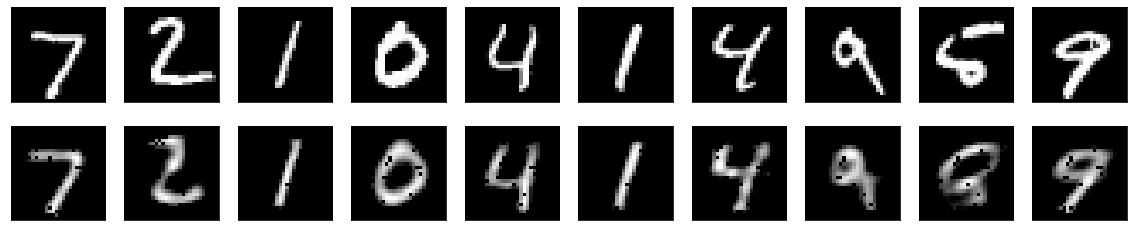

In [29]:
with torch.no_grad():
    number = 10
    plt.figure(figsize=(20, 4))
    for index in range(number):
        # display original
        ax = plt.subplot(2, number, index + 1)
        plt.imshow(test_examples[index].numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, number, index + 1 + number)
        plt.imshow(reconstruction[index].numpy().reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

In [40]:
print(encoder(test_examples[0:1]))

tensor([[0.3380, 0.1752, 0.0000, 0.6237, 0.0808, 0.0451, 0.0000, 0.0000, 0.1087,
         0.2921, 0.0000, 0.5814, 0.0000, 0.1479, 0.0000, 0.0200]],
       grad_fn=<DivBackward0>)
